In [1]:
import sys
sys.path.append('/home/ahabis/2-Scribble_project')
from config import *
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from uncertainty_metrics import *

In [2]:
def metrics(predictions, trues):
    tp = np.sum((predictions) * trues)
    tn = np.sum((1 - predictions) * (1 - trues))
    fp = np.sum((predictions) * (1 - trues))
    fn = np.sum((1 - predictions) * trues)
    eps = 1e-6
    precision_healthy = tn / (tn + fn + eps)
    precision_tumor = tp / (tp + fp + eps)
    # print(precision_tumor)
    m_precision = (precision_healthy + precision_tumor) / 2
    recall_tumor = tp / (tp + fn + eps)
    # print(recall_tumor)

    recall_healthy = tn / (tn + fp + eps)
    m_recall = (recall_tumor + recall_healthy) / 2
    f1 = 2 * (m_precision * m_recall) / (m_precision + m_recall + eps)
    balanced_accuracy = (m_precision + m_recall) / 2
    
    return balanced_accuracy, m_precision, m_recall, f1

In [3]:
image_list = os.listdir(path_prediction_features)
normalized_stds = np.zeros(len(image_list))
normalized_entropies = np.zeros(len(image_list))
# normalized_binary_ratios = np.zeros(len(image_list))
images_f_scores = np.zeros(len(image_list))

for i, image in enumerate(image_list[:]):

    current_image_prediction_path = os.path.join(path_prediction_features, image, 'predictions.npy')
    current_image_trues_path = os.path.join(path_prediction_features, image, 'trues.npy')
    trues = np.load(current_image_trues_path)
    mc_predictions = np.squeeze(np.load(current_image_prediction_path))
    # print(mc_predictions.shape)
    # STDs
    normalized_stds[i] = compute_std(mc_predictions,
                                     patch_level=False,
                                     optimal_threshold=0.33)
    # Entropy
    normalized_entropies[i] = compute_entropy(mc_predictions,
                                              patch_level=False,
                                              optimal_threshold=0.33)
    # normalized_binary_ratios[i] = compute_minority_vote_ratio(mc_predictions, patch_level=False)
    #F1 Scores
    f1 = metrics(np.mean(mc_predictions,0),trues)[3]
    images_f_scores[i] = f1

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


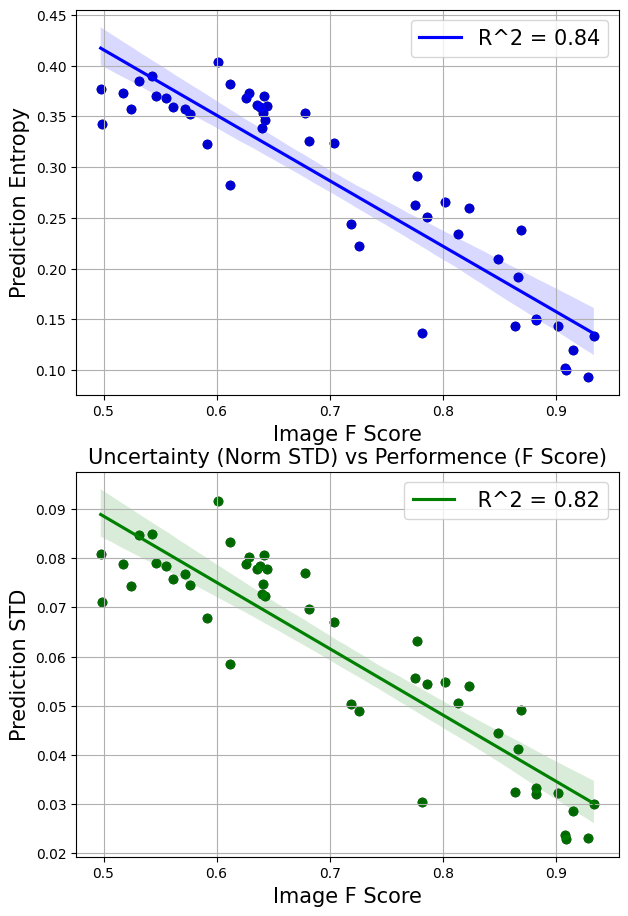

In [6]:
# plot the uncertainty as a function of the prediction quality
x1 = images_f_scores
y1 = normalized_entropies
y2 = normalized_stds
# y3 = normalized_binary_ratios

f, axs = plt.subplots(2, 1, figsize=(7, 11))

plt.subplot(2, 1, 1)
plt.grid()

plt.scatter(x1, y1, color = 'k')
plt.xlabel("Image F Score", fontsize="15")
plt.ylabel("Prediction Entropy", fontsize="15")
# plt.title("Uncertainty (Norm Entropy) vs Performence (F Score)", fontsize="15")

slope, intercept, r_value, p_value, std_err = stats.linregress(x1, y1)

ax1 = sns.regplot(
    x1,
    y1,
    color="b",
    line_kws={"label": "R^2 = {}".format(np.round(r_value**2,2))},
)
plt.annotate("r-squared = ", xy=(0.5, 0.5))

ax1.legend(fontsize="15")
plt.subplot(2, 1, 2)
plt.grid()

plt.scatter(x1, y2, color = 'k')
plt.xlabel("Image F Score", fontsize="15")
plt.ylabel("Prediction STD", fontsize="15")
plt.title("Uncertainty (Norm STD) vs Performence (F Score)", fontsize="15")
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x1, y2)
ax2 = sns.regplot(
    x1,
    y2,
    color="g",
    line_kws={"label": " R^2 = {}".format(np.round(r_value2**2,2))},
)
plt.annotate("r-squared = ", xy=(0.5, 0.5))
ax2.legend(fontsize="15")
plt.show()